In [2]:
import argparse
import random
import numpy as np
from habitat_baselines.config.default import get_config
import habitat
import os
from habitat import Config, logger
from habitat import Config, Dataset
import matplotlib.pyplot as plt
import transformations as tf

In [3]:
import contextlib
import time
from collections import OrderedDict, defaultdict, deque
from typing import Any, Dict, List, Optional
from habitat_baselines.rl.ddppo.algo.ddp_utils import (
    EXIT,
    REQUEUE,
    add_signal_handlers,
    init_distrib_slurm,
    load_interrupted_state,
    requeue_job,
    save_interrupted_state,
)
from habitat_baselines.common.baseline_registry import baseline_registry
#from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.common.utils import batch_obs, linear_decay
import numpy as np
import torch
import torch.distributed as distrib
import torch.nn as nn
from gym import spaces
from gym.spaces.dict_space import Dict as SpaceDict
from torch.optim.lr_scheduler import LambdaLR
from habitat_baselines.rl.ddppo.policy.resnet_policy import PointNavResNetPolicy
from habitat_baselines.rl.ddppo.algo.ddppo import DDPPO
from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry

In [4]:
from ppotrainer import PPOTrainer
from ddpotrainer import DDPPOTrainer
from constructenv import construct_envs
from env import MyRLEnv, NavRLEnv1, MyRLEnvNew
from habitat import make_dataset
from constructenv import make_env_fn
from vectorenv import VectorEnv
from utils import FrameSkip, FrameStack, draw_top_down_map

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Config init

In [6]:
import fileinput
filename = "/habitat-api/habitat_baselines/config/pointnav/ddppo_pointnav.yaml"
with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace('\"configs/tasks/pointnav_gibson.yaml\"', '\"/habitat-api/configs/tasks/pointnav_gibson.yaml\"'), end='')
with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:        
    for line in file:    
        print(line.replace('GLOO', 'NCCL'), end='')

In [7]:
W = 256#640
H = 256#360
config_paths="/data/challenge_pointnav2020.local.rgbd.yaml"
config = habitat.get_config(config_paths=config_paths)
config.defrost()
config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.DATASET.DATA_PATH = '/data/v1/{split}/{split}.json.gz'
config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS = ["HEADING_SENSOR", "COMPASS_SENSOR", "GPS_SENSOR", "POINTGOAL_SENSOR", "POINTGOAL_WITH_GPS_COMPASS_SENSOR"]
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_WITH_GPS_COMPASS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.POINTGOAL_SENSOR.DIMENSIONALITY = 3
config.TASK.POINTGOAL_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.GPS_SENSOR.DIMENSIONALITY = 3
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"
config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
config.TASK.AGENT_POSITION_SENSOR.TYPE = "position_sensor"
config.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")
config.SIMULATOR.TURN_ANGLE = 2
config.SIMULATOR.TILT_ANGLE = 2
config.SIMULATOR.FORWARD_STEP_SIZE = 0.15
config.ENVIRONMENT.MAX_EPISODE_STEPS = 500
config.TASK.TOP_DOWN_MAP.MAX_EPISODE_STEPS = 500
config.DATASET.SCENES_DIR = '/data'
config.DATASET.SPLIT = 'train'
config.SIMULATOR.SCENE = '/data/gibson/Aldrich.glb'
#config.SIMULATOR_GPU_ID = 0
config.freeze()

In [8]:
config2 = get_config('/habitat-api/habitat_baselines/config/pointnav/ddppo_pointnav.yaml', [])
ii = 0
for i in config2.TASK_CONFIG.keys():
    config2.TASK_CONFIG[i] = config[i]
    ii+=1
config = config2    

In [9]:
config.defrost()
config.TASK_CONFIG.DATASET.DATA_PATH = '/data/v1/{split}/{split}.json.gz'
config.TASK_CONFIG.DATASET.SCENES_DIR = '/data'
config.TASK_CONFIG.DATASET.SPLIT = 'train'
config.TASK_CONFIG.SIMULATOR.SCENE = '/data/gibson/Aldrich.glb'
config.TASK_CONFIG.TASK.GOAL_SENSOR_UUID = 'pos'#'pointgoal_with_gps_compass'
config.NUM_UPDATES = 50000
config.ENV_NAME = 'MyRLEnvNew'
config.NUM_PROCESSES = 2
config.freeze()

## Construct one env (example)

In [10]:
print(config.ENV_NAME)
env_class = get_env_class(config.ENV_NAME)
dataset = make_dataset(config.TASK_CONFIG.DATASET.TYPE, config=config.TASK_CONFIG.DATASET)
one_env = env_class(config=config, dataset=dataset)

2020-04-04 19:24:08,294 Initializing dataset PointNav-v1


MyRLEnvNew


2020-04-04 19:25:56,470 initializing sim Sim-v0
2020-04-04 19:26:00,291 Initializing task Nav-v0


In [79]:
obs = one_env.reset()

Env is done:  False
Current coordinates:  [-0.0, 0.0]
Goal coordinates:  [-3.340554742249153, -5.819871977939876]
Distance to goal:  [3.34055474 5.81987198]


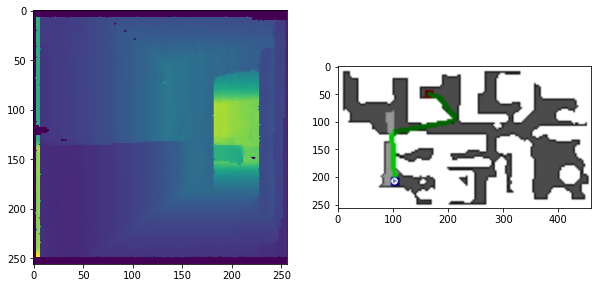

In [203]:
observations, rewards, dones, infos = one_env.step(action=3)
top_down_map = draw_top_down_map(infos, one_env.obs[0]["heading"][0], one_env.obs[0]['rgb'][0].shape[0])
plt.rcParams["figure.figsize"] = [10,10]
plt.subplot(1, 2, 1)
plt.imshow(observations['depth'][:,:,0])
plt.subplot(1, 2, 2)
plt.imshow(top_down_map)
print('Env is done: ',dones)
print('Current coordinates: ',[one_env.trux,one_env.truy])
print('Goal coordinates: ',[one_env.goalx, one_env.goaly])
print('Distance to goal: ',observations['pos'])

## Construct multiple envs with VectorEnv (example)

In [81]:
num_processes = config.NUM_PROCESSES
configs = [config.clone() for i in range(num_processes)]
env_class = get_env_class(config.ENV_NAME)
env_classes = [env_class for _ in range(num_processes)]

envs = VectorEnv(make_env_fn=make_env_fn,
                env_fn_args=tuple(tuple(zip(configs, env_classes, range(num_processes)))))

In [208]:
obs = envs.reset()

Env is done:  [False, False]
Current coordinates:  [[-0.0, 0.0], [-0.0, 0.0]]
Goal coordinates:  [[4.054014423957562, 6.589682173896374], [-6.6853491250986234, -1.5612027785249727]]
Distance to goal:  [[-4.054014423957562, -6.589682173896374], [6.6853491250986234, 1.5612027785249727]]


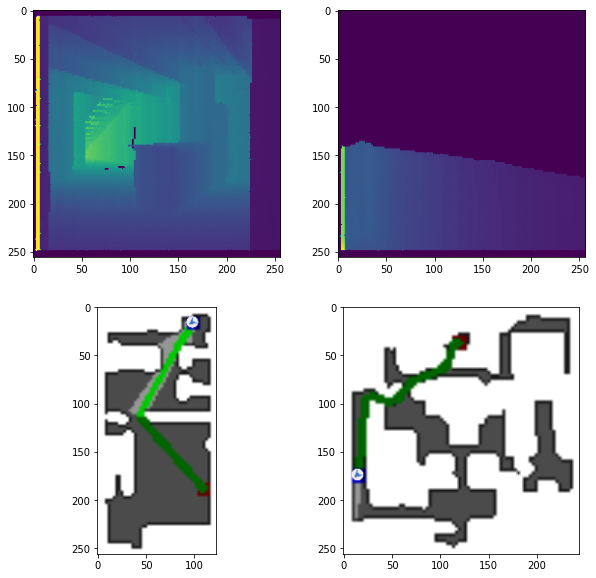

In [209]:
outputs = envs.step([2,2,2,2])

observations, rewards, dones, infos = [list(x) for x in zip(*outputs)]

OBSERVATION_SPACE_COMMAND = 'obs'
for write_fn in envs._connection_write_fns:
    write_fn((OBSERVATION_SPACE_COMMAND, None))
obs = [read_fn() for read_fn in envs._connection_read_fns]

OBSERVATION_SPACE_COMMAND = ['trux','truy','goalx','goaly']
for i,command in enumerate(OBSERVATION_SPACE_COMMAND):
    for write_fn in envs._connection_write_fns:
        write_fn((command, None))
    OBSERVATION_SPACE_COMMAND[i] = [read_fn() for read_fn in envs._connection_read_fns]

figure, axes = plt.subplots(nrows=2, ncols=config.NUM_PROCESSES)
for i in range(config.NUM_PROCESSES):
    top_down_map = draw_top_down_map(infos[i], obs[i][0]["heading"][0], obs[i][0]['rgb'][0].shape[0])
    axes[0, i].imshow(observations[i]['depth'][:,:,0])
    axes[1, i].imshow(top_down_map)
    
print('Env is done: ',dones)
print('Current coordinates: ',list(map(list, zip(*OBSERVATION_SPACE_COMMAND[:2]))))
print('Goal coordinates: ',list(map(list, zip(*OBSERVATION_SPACE_COMMAND[2:]))))
print('Distance to goal: ',[list(observations[i]['pos']) for i in range(config.NUM_PROCESSES)])

## How to communicate with VectorEnv manually (example)

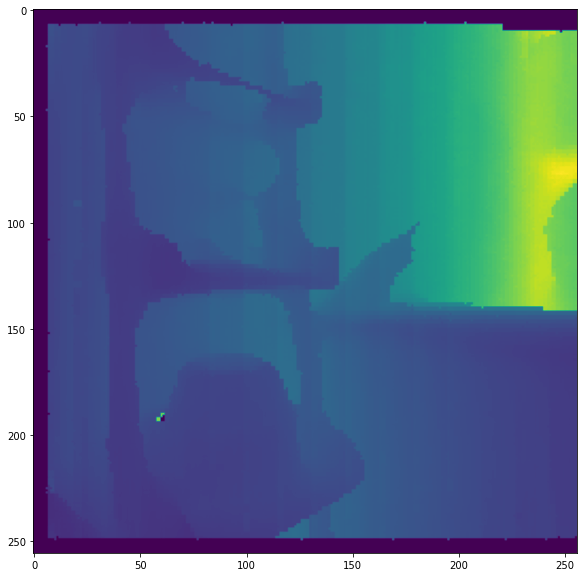

In [167]:
data = [0,0,0,0]
STEP_COMMAND = "step"

if isinstance(data[0], (int, np.integer, str)):
    data = [{"action": {"action": action}} for action in data]
envs._is_waiting = True
for write_fn, args in zip(envs._connection_write_fns, data):
    write_fn((STEP_COMMAND, args))

outputs = []
for read_fn in envs._connection_read_fns:
    outputs.append(read_fn())
observations, rewards, dones, infos = [list(x) for x in zip(*outputs)]    
envs._is_waiting = False
plt.imshow(observations[1]['depth'][:,:,0])

# Run training process

In [168]:
random.seed(config.TASK_CONFIG.SEED)
np.random.seed(config.TASK_CONFIG.SEED)

In [169]:
trainer_init = baseline_registry.get_trainer(config.TRAINER_NAME)

In [170]:
trainer = trainer_init(config)

2020-04-04 20:10:47,695 config: BASE_TASK_CONFIG_PATH: /habitat-api/configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: 50
CMD_TRAILING_OPTS: []
ENV_NAME: MyRLEnvNew
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
LOG_FILE: train.log
LOG_INTERVAL: 10
NUM_PROCESSES: 2
NUM_UPDATES: 50000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
RL:
  DDPPO:
    backbone: resnet50
    distrib_backend: NCCL
    num_recurrent_layers: 2
    pretrained: Fals

In [ ]:
trainer.train()